In [1]:
import torch
import torch_geometric.transforms as T
import torch.nn as nn

from tqdm import tqdm
from torch.optim import Adam
from torch.nn import functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE, GraphConv
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = Planetoid(root='', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)

/home/lab303/anaconda3/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [3]:
data

Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

In [4]:
epochs = 300
lr = 0.01
hidden1 = 32
hidden2 = 16
dropout = 0

input_channels = data.num_node_features
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_channels, device

(1433, device(type='cuda', index=0))

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout):
        super(Encoder, self).__init__()
        self.conv1 = GraphConv(input_dim, hidden1)
        self.conv_mu = GraphConv(hidden1, hidden2)
        self.conv_logstd = GraphConv(hidden1, hidden2)
        self.dropout = dropout
        self.edge_index = None

    def conv_layer(self, x, conv):
        x = F.dropout(x, p=self.dropout, training=self.training)
        hidden = conv(x, self.edge_index)
        hidden = F.relu(hidden, True)
        return hidden

    def forward(self, x, edge_index):
        self.edge_index = edge_index
        hidden1 = self.conv_layer(x, self.conv1)
        return self.conv_mu(hidden1, edge_index), self.conv_logstd(hidden1, edge_index)


In [6]:
encoder = Encoder(input_channels, hidden1, hidden2, dropout)
model = VGAE(encoder).to(device)
optimizer = Adam(model.parameters(), lr)

In [7]:
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

In [8]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index) + model.kl_loss() / data.num_nodes
    loss.backward()
    optimizer.step()
    return loss.item()

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        return model.test(z, pos_edge_index, neg_edge_index)

In [9]:
writer = SummaryWriter('runs/VGAE_experiment_'+'300 epochs')

In [10]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    writer.add_scalar('auc train',auc,epoch)
    writer.add_scalar('ap train',ap,epoch)   

Epoch: 001, AUC: 0.6020, AP: 0.6409
Epoch: 002, AUC: 0.5809, AP: 0.6228
Epoch: 003, AUC: 0.5822, AP: 0.6221
Epoch: 004, AUC: 0.5787, AP: 0.6211
Epoch: 005, AUC: 0.5825, AP: 0.6287
Epoch: 006, AUC: 0.6009, AP: 0.6490
Epoch: 007, AUC: 0.6186, AP: 0.6659
Epoch: 008, AUC: 0.6318, AP: 0.6777
Epoch: 009, AUC: 0.6379, AP: 0.6861
Epoch: 010, AUC: 0.6471, AP: 0.6943
Epoch: 011, AUC: 0.6582, AP: 0.7032
Epoch: 012, AUC: 0.6723, AP: 0.7104
Epoch: 013, AUC: 0.6807, AP: 0.7103
Epoch: 014, AUC: 0.6837, AP: 0.7048
Epoch: 015, AUC: 0.6830, AP: 0.6990
Epoch: 016, AUC: 0.6831, AP: 0.6957
Epoch: 017, AUC: 0.6899, AP: 0.7011
Epoch: 018, AUC: 0.7088, AP: 0.7180
Epoch: 019, AUC: 0.7153, AP: 0.7299
Epoch: 020, AUC: 0.7159, AP: 0.7351
Epoch: 021, AUC: 0.7246, AP: 0.7399
Epoch: 022, AUC: 0.7328, AP: 0.7415
Epoch: 023, AUC: 0.7409, AP: 0.7470
Epoch: 024, AUC: 0.7465, AP: 0.7554
Epoch: 025, AUC: 0.7480, AP: 0.7595
Epoch: 026, AUC: 0.7501, AP: 0.7605
Epoch: 027, AUC: 0.7536, AP: 0.7641
Epoch: 028, AUC: 0.7610, AP:

Epoch: 229, AUC: 0.8849, AP: 0.8961
Epoch: 230, AUC: 0.8829, AP: 0.8942
Epoch: 231, AUC: 0.8823, AP: 0.8930
Epoch: 232, AUC: 0.8836, AP: 0.8937
Epoch: 233, AUC: 0.8848, AP: 0.8946
Epoch: 234, AUC: 0.8851, AP: 0.8945
Epoch: 235, AUC: 0.8852, AP: 0.8947
Epoch: 236, AUC: 0.8853, AP: 0.8948
Epoch: 237, AUC: 0.8852, AP: 0.8944
Epoch: 238, AUC: 0.8850, AP: 0.8946
Epoch: 239, AUC: 0.8848, AP: 0.8946
Epoch: 240, AUC: 0.8857, AP: 0.8952
Epoch: 241, AUC: 0.8860, AP: 0.8958
Epoch: 242, AUC: 0.8849, AP: 0.8952
Epoch: 243, AUC: 0.8843, AP: 0.8954
Epoch: 244, AUC: 0.8844, AP: 0.8955
Epoch: 245, AUC: 0.8847, AP: 0.8954
Epoch: 246, AUC: 0.8857, AP: 0.8964
Epoch: 247, AUC: 0.8857, AP: 0.8969
Epoch: 248, AUC: 0.8858, AP: 0.8974
Epoch: 249, AUC: 0.8846, AP: 0.8961
Epoch: 250, AUC: 0.8845, AP: 0.8956
Epoch: 251, AUC: 0.8848, AP: 0.8960
Epoch: 252, AUC: 0.8860, AP: 0.8971
Epoch: 253, AUC: 0.8867, AP: 0.8976
Epoch: 254, AUC: 0.8872, AP: 0.8975
Epoch: 255, AUC: 0.8872, AP: 0.8970
Epoch: 256, AUC: 0.8867, AP:

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(x, train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

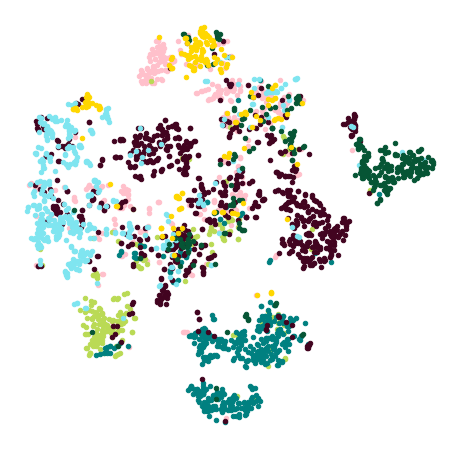

In [12]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)